# Overview

Contact Map Explorer is a tool for studying contacts in biomolecules. It builds on tools in MDTraj. These notebooks teach how to use Contact Map Explorer by showing examples.

As our initial example system, we'll use part of a trajectory of the KRas protein bound to GTP, which was provided by Sander Roet. KRas is a protein that plays a role in many cancers. For simplicity, the waters were removed from the trajectory (although ions are still included). To run this notebook, download the example files from https://figshare.com/s/453b1b215cf2f9270769 (total download size about 1.2 MB). Download all files, and extract in the same directory that you started Jupyter from (so that you have a directory called `5550217` in your current working directory).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mdtraj as md
traj = md.load("5550217/kras.xtc", top="5550217/kras.pdb")
topology = traj.topology

In [2]:
from contact_map import ContactFrequency, ContactDifference

## Contact map for a single frame

First we make the contact map for the 0th frame. For default parameters (and how to change them) see the notebook called "Changing defaults."

In [3]:
%%time
frame_contacts = ContactFrequency(traj[0])

CPU times: user 240 ms, sys: 22 ms, total: 262 ms
Wall time: 80.8 ms


Plotting requires matplotlib, and the default plotting parameters use the `'seismic'` colormap. For details on customizing the appearance of the contact map plots, see the notebook on "Customizing contact map plots."

CPU times: user 517 ms, sys: 3.52 ms, total: 521 ms
Wall time: 517 ms


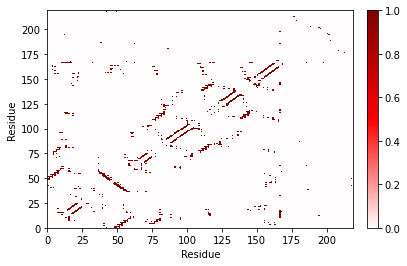

In [4]:
%%time
fig, ax = frame_contacts.residue_contacts.plot()
plt.xlabel("Residue")
_ = plt.ylabel("Residue")
# setting the return of plt.ylabel to the dummy var _ is a way to swallow output

## Contact map for a trajectory

If you provide a single frame, the values in the contact map are 0 or 1: either the contact was present or it was not. But if you provide a longer trajectory, the values in the contact map are the fraction of frames during which the contact was present.

Other than using the entire trajectory, the process is exactly the same as for the single-frame example.

In [5]:
%%time
traj_contacts = ContactFrequency(traj)

CPU times: user 19.1 s, sys: 53.1 ms, total: 19.1 s
Wall time: 3 s


CPU times: user 1.67 s, sys: 2.98 ms, total: 1.68 s
Wall time: 1.67 s


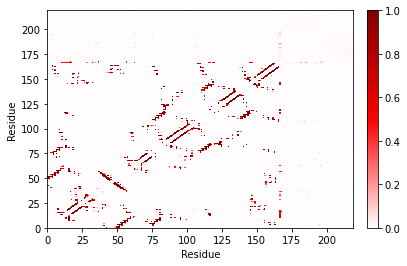

In [6]:
%%time
fig, ax = traj_contacts.residue_contacts.plot()
plt.xlabel("Residue")
_ = plt.ylabel("Residue")

Note that some of the reds are a little lighter now -- these contacts were not present 100% of the time!

If we want to save the figure, we can use matplotlib's savefig functionality:

In [7]:
fig.savefig("traj_contacts.pdf")

If we want to save the contact data to a file for later usage, we can also do that:

In [8]:
traj_contacts.save_to_file("traj_contacts.p")

In [9]:
# to reload it:
ContactFrequency.from_file("traj_contacts.p")

For many users, this is all that Contact Map Explorer is needed for. You can make publication-quality figures in only a few lines of Python. However, Contact Map Explorer is also intended to help you analyze your data and help you understand it better. The rest of this notebook, and other notebooks in the documentation, will show you some of the possibilities.

## Differences between contact maps

One question you might have is, how do two contact maps differ? For this purpose, we can calculate contact map differences.

In [10]:
%%time
diff = traj_contacts - frame_contacts
# equivalently:  diff = ContactDifference(traj_contacts, frame_contacts)

CPU times: user 27.6 ms, sys: 0 ns, total: 27.6 ms
Wall time: 27.3 ms


CPU times: user 1.8 s, sys: 15.2 ms, total: 1.81 s
Wall time: 1.81 s


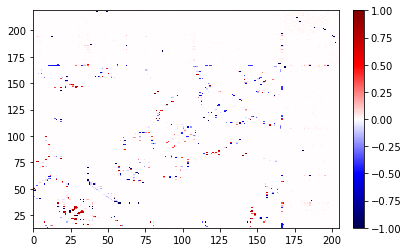

In [11]:
%%time
fig, ax = diff.residue_contacts.plot()


The contact map gives a lot of information, and frequently we want to ask follow-up questions. We'll looks at the results from the difference above, but all the same techniques apply to any contact results.


For example, after looking at that difference, we might want to know which were much more likely to be in the full trajectory than in the single frame:

In [12]:
# show the 10 with the highest value
diff.residue_contacts.most_common()[:10]

[([ALA146, GLN22], 0.9900990099009901),
 ([PHE82, PHE141], 0.9801980198019802),
 ([ILE84, GLU143], 0.9702970297029703),
 ([ALA83, LYS117], 0.9702970297029703),
 ([PHE90, ALA130], 0.9702970297029703),
 ([ALA146, ASN116], 0.9702970297029703),
 ([LEU113, ILE139], 0.9504950495049505),
 ([ALA155, VAL152], 0.9504950495049505),
 ([LEU19, LEU79], 0.9405940594059405),
 ([VAL81, ILE93], 0.9405940594059405)]

If you wanted to see the *least* common (that is, the ones from the single frame that were least likely to be in the rest of the trajectory), you can use standard Python tricks for reversing a list:

In [13]:
list(reversed(diff.residue_contacts.most_common()))[:10]

[([THR50, CL6865], -0.9900990099009901),
 ([NA6824, CL6860], -0.9900990099009901),
 ([TYR40, TYR32], -0.9900990099009901),
 ([NA6828, THR87], -0.9900990099009901),
 ([CL6849, NA6842], -0.9900990099009901),
 ([NA6834, SER39], -0.9900990099009901),
 ([ALA59, GLU37], -0.9900990099009901),
 ([PRO34, ASP38], -0.9900990099009901),
 ([GLN25, ASP30], -0.9900990099009901),
 ([NA6842, GLY13], -0.9900990099009901)]

What if you wanted to know which residues were most commonly in contact with a specific residue, say the GTP in KRAS? First, we need to get the `Residue` object for the GTP from the MDTraj topology:

In [14]:
gtp201 = topology.residue(166)
print(gtp201)  # it's good to print this to double-check you got the right one!

GTP201


We extended the standard `.most_common()` to take an optional argument. When the argument is given, it will filter the output to only include the ones where that argument is part of the contact. So to get the most common residue-residue contacts involving GTP201:

In [15]:
for contact in traj_contacts.residue_contacts.most_common(gtp201):
    if contact[1] > 0.1:
        print(contact)

([GTP201, LEU120], 0.6435643564356436)
([GTP201, ASP119], 0.6237623762376238)
([LYS147, GTP201], 0.6138613861386139)
([SER145, GTP201], 0.594059405940594)
([ALA146, GTP201], 0.594059405940594)
([LYS117, GTP201], 0.594059405940594)
([ASP33, GTP201], 0.5742574257425742)
([GLY12, GTP201], 0.5643564356435643)
([GLY13, GTP201], 0.5544554455445545)
([VAL14, GTP201], 0.5346534653465347)
([ALA11, GTP201], 0.5346534653465347)
([ALA18, GTP201], 0.5247524752475248)
([GTP201, GLY15], 0.5247524752475248)
([SER17, GTP201], 0.5247524752475248)
([GTP201, LYS16], 0.5247524752475248)
([ASN116, GTP201], 0.4752475247524752)
([ASP57, GTP201], 0.40594059405940597)
([GTP201, GLU63], 0.39603960396039606)
([GLU37, GTP201], 0.3465346534653465)
([VAL29, GTP201], 0.297029702970297)
([NA6833, GTP201], 0.2079207920792079)
([NA6843, GTP201], 0.18811881188118812)
([THR35, GTP201], 0.1485148514851485)
([PRO34, GTP201], 0.1485148514851485)
([NA6829, GTP201], 0.1485148514851485)


## Finding atoms associated with residue contacts

One of the particularly useful features of Contact Map Explorer is that it preserves information about the atom-atom contacts, as well as the residue-residue contacts.

Above, we looked at which residues were more commonly in contact with GTP201. But what if we wanted to know which atom-atom contacts involved GTP201? We can do that with `contacts.most_common_atoms_for_residue`. 

In [16]:
traj_contacts.most_common_atoms_for_residue(gtp201)[:10]

[([ASP119-CG, GTP201-N1], 0.6138613861386139),
 ([GTP201-C2, ASP119-CG], 0.6138613861386139),
 ([GTP201-C2, ASP119-OD2], 0.6138613861386139),
 ([GTP201-N2, ASP119-CG], 0.6138613861386139),
 ([ASP119-OD2, GTP201-N1], 0.6138613861386139),
 ([GTP201-N2, ASP119-OD2], 0.6138613861386139),
 ([GTP201-N2, LEU120-CD2], 0.6039603960396039),
 ([ASP119-OD1, GTP201-N1], 0.6039603960396039),
 ([GTP201-C2, ASP119-OD1], 0.6039603960396039),
 ([GTP201-N2, ASP119-OD1], 0.6039603960396039)]

On the other hand, what if you wanted to know the most common atoms for a specific contact pair? Let's do that for the contact pair Val81-Asn116. First we'll get the residue objects, then we'll use the `most_common_atoms_for_contact` method.

In [17]:
val81 = topology.residue(80)
asn116 = topology.residue(115)
print(val81, asn116)

VAL81 ASN116


In [18]:
traj_contacts.most_common_atoms_for_contact([val81, asn116])

[([ASN116-CB, VAL81-CG1], 0.9702970297029703),
 ([VAL81-CG1, ASN116-CG], 0.24752475247524752),
 ([VAL81-CG1, ASN116-ND2], 0.21782178217821782),
 ([VAL81-CG1, ASN116-N], 0.0594059405940594)]

## Atom-atom contact maps

In addition to residue-residue contacts, Contact Map Explorer also keeps information about atom-atom contacts. Everything done above with `contacts.residue_contacts` can also be done with `contacts.atom_contacts`. 

### Plotting atom-atom contacts

We can plot atom-atom contacts, but because the matrix is so large, there are often problems displaying it because there aren't enough pixels on the screen.

/home/sander/github_files/contact_map/contact_map/contact_count.py:238: RuntimeWarning: The number of pixels in the figure is insufficient to show all the contacts.
 Please save this as a vector image (such as a PDF) to view the correct result.
 Another option is to increase the 'dpi' (currently: 72.0), or the 'figsize' (currently: (6.0, 4.0)).
 Recommended minimum amount of pixels = (2722, 2722) (width, height).
  warnings.warn(msg, RuntimeWarning)


CPU times: user 13 s, sys: 194 ms, total: 13.2 s
Wall time: 13.3 s


(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

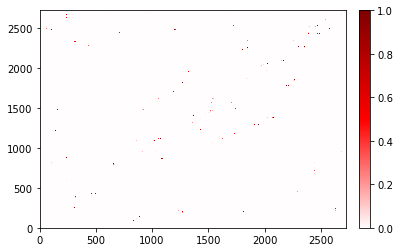

In [19]:
%%time
traj_contacts.atom_contacts.plot();

You'll notice that you don't see many points here. As the warning states: That is because the points are smaller than a single pixel at this resolution. To fix that, output or save this figure as a vector image (like PDF), increase the figure's size (by using the `figsize` parameter) or resolution (by using the `dpi` parameter), or both. 

To get Jupyter to output PDF by default instead of PNG:

```python
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf')
```

To increase the figure size:

```python
traj_contacts.atom_contacts.plot(figsize=(38, 38))
```

To increase DPI (and make the figure square):

```python
traj_contacts.atom_contacts.plot(figsize=(6, 6), dpi=454)
```

### Using `most_common`

The `most_common` method works the same on atom contacts as on residue contacts.

In [20]:
traj_contacts.atom_contacts.most_common()[:10]

[([ASP92-C, TYR96-CD2], 1.0),
 ([SER136-C, LEU133-O], 1.0),
 ([LEU159-CB, PHE156-O], 1.0),
 ([ILE93-C, TYR96-N], 1.0),
 ([ARG123-CA, ILE84-O], 1.0),
 ([ASP54-O, LYS5-CA], 1.0),
 ([THR124-CA, ILE84-O], 1.0),
 ([VAL7-O, PHE78-CA], 1.0),
 ([ASP92-O, HIS95-CA], 1.0),
 ([SER136-CB, LEU133-O], 1.0)]

In [21]:
asn116cb = topology.atom(1809)
print(asn116cb)

ASN116-CB


In [22]:
traj_contacts.atom_contacts.most_common(asn116cb)

[([PHE82-O, ASN116-CB], 1.0),
 ([ASN116-CB, VAL14-O], 1.0),
 ([ASN116-CB, VAL81-CG1], 0.9702970297029703),
 ([ASN116-CB, THR144-OG1], 0.9405940594059405),
 ([ASN116-CB, THR144-O], 0.6633663366336634),
 ([PHE82-C, ASN116-CB], 0.5643564356435643),
 ([ASN116-CB, ALA83-CA], 0.27722772277227725),
 ([ASN116-CB, ALA83-CB], 0.0891089108910891),
 ([ASN116-CB, ALA83-N], 0.019801980198019802)]